# AI for Earth System Science Hackathon 2020
# HOLODEC Machine Learning Challenge Problem
Matt Hayman, Aaron Bansemer, David John Gagne, Gabrielle Gantos, Gunther Wallach

## Introduction
![holodec probe on aircraft](holodec_images/image2.png)

The properties of the water and ice particles in clouds are critical to many aspects of weather and climate.  The size, shape, and concentration of ice particles control the radiative properties of cirrus clouds.  The spatial distribution of water droplets in warm clouds may influence the formation of drizzle and rain.  The interactions among droplets, ice particles, and aerosols impact precipitation, lightning, atmospheric chemistry, and more.  Measurements of natural cloud particles are often taken aboard research aircraft with instruments mounted on the wings.  One of the newer technologies used for these instruments is inline holographic imaging, which has the important advantage of being able to instantaneously record all of the particles inside a small volume of air.  Using this technology, the Holographic Detector for Clouds (HOLODEC) has been developed by the university community and NCAR to improve our cloud measurement capabilities.

A hologram captures electro-magnatic field amplitude and phase (or wavefront) incident on a detector.  In contrast, standard imaging captures only the amplitude of the electric field.  Unlike a standard image, holograms can be computationally refocused on any object within the capture volume using standard wave propagation calculations. The figure below shows an example of an inline hologram (large image) with five out of focus particles.  The five smaller images show the reconstruction from each particle by computationally propagating the electro-magnetic field back to the depth position of each particle. 

![holodec example images](holodec_images/image5.png)

HOLODEC is an airborne holographic cloud imager capable of capturing particle size distributions in a single shot, so a measured particle size distribution is localized to a specific part of the cloud (not accumulated over a long path length).  By capturing a hologram, each particle can be imaged irrespective of its location in the sample volume, and its size and position can be accurately captured.

While holographic imaging provides unparalleled information about cloud particles, processing the raw holograms is also computationally expensive.  Lacking prior knowledge of the particle position in depth, a typical HOLODEC hologram is reconstructed at 1000 planes (or depths) using standard diffraction calculations.  At each plane, a particle’s image sharpness is evaluated and the particle size and position is determined only at a plane where it is in focus.  In addition to the computational cost, the processing requires human intervention to recognize when a “particle” is really just artifacts of interfering scattered fields.

The objective of this project is to develop a machine learning solution to process HOLODEC data that is more computationally efficient than the first-principles based processor.  

An important factor in processing hologram data is that the scattered field from a particle spreads out as it propagates.  The image below shows the scattered field from a 50 µm particle at distances in increments of 0.1 mm from the particle (0 to 0.7 mm).  As the scattered field expands, it’s the power is also distributed over a larger area.

![holodec 3d](holodec_images/image1.png)

For simplicity, this project deals with simulated holographic data where particle shapes are limited to spheres.  Two datasets are provided.  The first dataset contains only one particle per hologram.  If you are successful in processing the first dataset, or you wish to immediately focus on a more challenging case, you can work on the second dataset that contains three particles per hologram.


## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* h5netcdf
* tqdm
* s3fs

In [ ]:
!pip install numpy scipy matplotlib xarray pandas scikit-learn tensorflow netcdf4 h5netcdf tqdm s3fs

In [8]:
! conda install zarr --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - zarr


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asciitree-0.3.3            |             py_2           6 KB  conda-forge
    fasteners-0.14.1           |             py_3          18 KB  conda-forge
    monotonic-1.5              |             py_0           9 KB  conda-forge
    numcodecs-0.6.4            |   py37he1b5a44_0         966 KB  conda-forge
    zarr-2.4.0                 |             py_0          95 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following NEW packages will be INSTALLED:

## Data
The data summary should contain the following pieces of information:
* Data generation procedure (satellite, model, etc.) 
* Link to website containing more information about dataset
* Time span of the dataset
* Geographic coverage of the dataset
* Parameter space coverage (if synthetic)


The datasets consist of synthetically-generated holograms of cloud droplets.  Each dataset is in netCDF format, and contains a series of hologram images as well as the properties of each particle in the image.  The netCDF variable names and properties are as follows:

| Variable Name | Description | Dimensions | Units/Range|
| ------------- | :----:|:----------- |:------|
| image  | Stack of single-color images. Each image is 600x400 pixels, ranging from 0-255 in intensity. | nHolograms, 600, 400 | 0 to 255 (grayscale image) |
| x  |  X-position of each particle in the dataset.  The origin is at the center of the hologram image. | nParticles (can vary) | -888 to 888 micrometers |
| y  | Y-position of each particle in the dataset.  The origin is at the center of the hologram image. |  nParticles (can vary) | -592 to 592 micrometers |
| z  | Z-position of each particle in the dataset.  The origin is at the focal plane of the instrument (all particles are unfocused). | nParticles (can vary) | 14000 to 158000 micrometers |
| d  | Diameter of each simulated droplet | nParticles (can vary) | 20 to 70 micrometers |
| hid | Hologram ID specifies which hologram this particle is contained in.  For example, if hid=1, the corresponding x, y, z, and d variables are found in the first hologram. | nParticles (can vary) | 1 to nHolograms |
| Dx (global attribute) | Resolution of each pixel, == 2.96 micrometers.  Use if you wish to convert x/y position to pixel number |  |  |

There are two datasets for this project, a single-particle dataset and a multi-particle dataset.  The single-particle dataset only contains one particle per hologram (nHolograms = nParticles). There are 50,000 holograms in the training dataset that correspond to 50,000 particles.

The three-particle dataset contains three particles per hologram.  This dataset also contains 50,000 holograms but 150,000 particles.  Be sure to use the hid variable to figure out which hologram a particle is contained in.

The goal of this project is to be able to find particles in the holograms and determine their x, y, z, and d values.

<center><img src='holodec_images/image4.png'><center>


### Potential Input Variables
| Variable Name | Units | Description | Relevance |
| ------------- | :----:|:----------- | :--------:|
| hologram   |  arbitrary |  8 bit (0-255) amplitude captured by CCD  | standard input data for processing  |


### Output Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| x  |  µm     |  particle horizontal position |
| y  |  µm     |  particle vertical position  |
| z  | µm  | particle position in depth (along the direction of propagation) |
| d  | µm  | particle diameter |
| hid | arbitrary | hologram ID by particle|


### Training Set

The single-particle training dataset is in the netCDF format described above, with 15,000 holograms and 15,000 corresponding particles.

The three-particle training dataset contains 15,000 holograms and 45,000 particles.


### Validation Set
The single-particle validation dataset is in the netCDF format described above, with 5,000 holograms and 5,000 corresponding particles.

The three-particle validation dataset contains 5,000 holograms and 15,000 particles.


### Test Set
The single-particle test dataset is in the netCDF format described above, with 5,000 holograms and 5,000 corresponding particles.

The three-particle test dataset contains 5,000 holograms and 15,000 particles.


### Data Transforms

The input images only need to be normalized between 0 and 1 by dividing by 255. The output *x*, *y*, *z*, and *d* should also be normalized using `sklearn.preprocessing` or a custom scalar. 


In [1]:
import argparse
import os
from os.path import join, exists
import sys
import s3fs
import yaml
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam, SGD
%matplotlib inline

In [7]:
# define some datset helper functions

num_particles_dict = {
    1 : '1particle',
    3 : '3particle'}

split_dict = {
    'train' : 'training',
    'test'   : 'test',
    'valid': 'validation'}

def dataset_name(num_particles, split, filetype="zarr"):
    """Return the dataset filename given user inputs"""
    
    valid = [1,3,'multi']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]
    
    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    
    return f'synthetic_holograms_{num_particles}_{split}_small.{filetype}'

def open_zarr(data_path, num_particles, split):
    data_path = os.path.join(data_path, dataset_name(num_particles, split))
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    store = s3fs.S3Map(root=data_path, s3=fs, check=False)
    return xr.open_zarr(store=store)

def scale_images(images):
    """Return images with pixel values between 0 and 1"""
    return images.astype(np.float32) / 255.

def flatten_dataset(df):
    """returns dataset with one row per hologram and all paricles flattened into columns"""
    columns = ["x1","y1","z1","d1","x2","y2","z2","d2","x3","y3","z3","d3"]
    data = []
    for hid in df['hid'].unique():
        vect = df.loc[df['hid'] == hid].drop(['hid'], axis=1).values
        data.append(vect.flatten())
    data = np.vstack(data)
    df = pd.DataFrame(data=data, columns=columns)
    return df

def load_scaled_datasets(data_path, num_particles, output_cols):
    """Given the dataset particle numbers, returns scaled training and validation dataframes."""
    
    beginning = datetime.now()
    print(f"BEGINNING: {beginning}")

    print("Slicing data into inputs/outputs")
    slice_time = datetime.now()
    train_ds = open_zarr(data_path, num_particles, 'train')
    val_ds = open_zarr(data_path, num_particles, 'valid')
    train_inputs = train_ds["image"].values
    train_outputs = train_ds[output_cols].to_dataframe()
    valid_inputs = val_ds["image"].values
    valid_outputs = val_ds[output_cols].to_dataframe()
    print(f"\t- time to slice datasets: {datetime.now() - slice_time}")
    
    print("\tScaling input data")
    scale_train_time = datetime.now()
    scaled_train_inputs = scale_images(train_inputs)
    print(f"\t\tscaled_train_inputs.shape: {train_inputs.shape}")
    print(f"\t\t- time to scale train input data: {datetime.now() - scale_train_time}")
    scale_valid_time = datetime.now()
    scaled_valid_inputs = scale_images(valid_inputs)
    print(f"\t\tscaled_valid_inputs.shape: {valid_inputs.shape}")
    print(f"\t\t- time to scale valid input data: {datetime.now() - scale_valid_time}")
    
    end = datetime.now()
    print(f"END: {end}\nTIME ELAPSED: {end - beginning}")
    train_ds.close()
    del train_ds
    val_ds.close()
    del val_ds
    return scaled_train_inputs, scaled_valid_inputs, train_outputs, valid_outputs


### Baseline Machine Learning Model
A baseline model for solving this problem uses a ConvNET architecture implemented in Keras.  The first three convolution layers consist of 5 x 5 pixel kernels with rectified linear unit (relu) activation followed by a 4 x 4 pixel max pool layer.  The first convolution layer has 8 channels, the second contains 16 channels, and the third contains 32 channels.  The output of the third convolution layer is flattened and fed into a dense layer with 64 neurons and relu activation which then feeds into a second dense layer with 32 neurons and relu activation.  Finally the output layer consists of 4 neurons (for x, y, z and d outputs) and linear activation.  The model is trained using a mean absolute error (MAE) loss function.

Mean absolute error in predictions for single-particle dataset:

| Variable Name | Error |
| ------------- |:----------- |
| x  |  20 µm     |
| y  |  12 µm     |
| z  |  2519 µm     |
| d  |  1 µm     |

Training time: 20 epochs in ~12 minutes

Mean absolute error in predictions for three-particle dataset:

| Variable Name | Error |
| ------------- |:----------- |
| x1  |  313 µm     |
| y1  |  217 µm     |
| z1  |  28872 µm     |
| d1  |  10 µm     |
| x2  |  326 µm     |
| y2  |  213 µm     |
| z2  |  28850 µm     |
| d2  |  10 µm     |
| x3  |  321 µm     |
| y3  |  212 µm     |
| z3  |  28580 µm     |
| d3  |  10 µm     |

Training time: 20 epochs in ~12 minutes


In [3]:
class Conv2DNeuralNetwork(object):
    """
    A Conv2D Neural Network Model that can support arbitrary numbers of layers.

    Attributes:
        filters: List of number of filters in each Conv2D layer
        kernel_sizes: List of kernel sizes in each Conv2D layer
        conv2d_activation: Type of activation function for conv2d layers
        pool_sizes: List of Max Pool sizes
        dense_sizes: Sizes of dense layers
        dense_activation: Type of activation function for dense layers
        learning_rate: Optimizer learning rate
        optimizer: Name of optimizer or optimizer object.
        loss: Name of loss function or loss object
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
    def __init__(self, filters=(8,), kernel_sizes=(5,), conv2d_activation="relu",
                 pool_sizes=(4,), dense_sizes=(64,), dense_activation="relu",
                 lr=0.001, optimizer="adam",  adam_beta_1=0.9, adam_beta_2=0.999,
                 sgd_momentum=0.9, decay=0, loss="mae", batch_size=32, epochs=2, verbose=0):
        self.filters = filters
        self.kernel_sizes = [tuple((v,v)) for v in kernel_sizes]
        self.conv2d_activation = conv2d_activation
        self.pool_sizes = [tuple((v,v)) for v in pool_sizes]
        self.dense_sizes = dense_sizes
        self.dense_activation = dense_activation
        self.lr = lr
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.sgd_momentum = sgd_momentum
        self.decay = decay
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = None

    def build_neural_network(self, input_shape, output_shape):
        """Create Keras neural network model and compile it."""
        conv_input = Input(shape=(input_shape), name="input")
        nn_model = conv_input
        for h in range(len(self.filters)):
            nn_model = Conv2D(self.filters[h], self.kernel_sizes[h], padding="same",
                              activation=self.conv2d_activation, name=f"conv2D_{h:02d}")(nn_model)
            nn_model = MaxPool2D(self.pool_sizes[h], name=f"maxpool2D_{h:02d}")(nn_model)
        nn_model = Flatten()(nn_model)
        for h in range(len(self.dense_sizes)):
            nn_model = Dense(self.dense_sizes[h], activation=self.dense_activation, name=f"dense_{h:02d}")(nn_model)
        nn_model = Dense(output_shape, name=f"dense_output")(nn_model)
        self.model = Model(conv_input, nn_model)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        self.model.summary()

    def fit(self, x, y):
        if len(x.shape[1:])==2:
            x = np.expand_dims(x, axis=-1)
        if len(y.shape) == 1:
            output_shape = 1
        else:
            output_shape = y.shape[1]
        input_shape = x.shape[1:]
        self.build_neural_network(input_shape, output_shape)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose)
        return

    def predict(self, x):
        y_out = self.model.predict(np.expand_dims(x.values, axis=-1), batch_size=self.batch_size)
        return y_out

    def predict_proba(self, x):
        y_prob = self.model.predict(x, batch_size=self.batch_size)
        return y_prob


In [4]:
# you can explore with whichever sklearn.processing or custom scalar
# you can also define a different sklearn or custom error functions
scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}
metrics = {"mae": mean_absolute_error}

In [5]:
# yaml file equivalent variable definitions

data_path = "ncar-aiml-data-commons/holodec/"
out_path = "./holodec_models/3particle_base/"
model_name = "cnn"
num_particles = 3
random_seed = 328942
output_cols = ["hid", "x", "y", "z", "d"]
metric = metrics["mae"]



In [6]:
# load and normalize data (this takes approximately 2 minutes)
scaled_train_inputs, \
scaled_valid_inputs, \
train_outputs, \
valid_outputs, = load_scaled_datasets(data_path,
                                    num_particles,
                                    output_cols)

BEGINNING: 2020-06-19 19:53:26.923915
Slicing data into inputs/outputs
	- time to slice datasets: 0:01:12.095856
	Scaling input data
		scaled_train_inputs.shape: (15000, 600, 400)
		- time to scale train input data: 0:00:23.272127
		scaled_valid_inputs.shape: (5000, 600, 400)
		- time to scale valid input data: 0:00:14.089233
END: 2020-06-19 19:55:16.381677
TIME ELAPSED: 0:01:49.457762


In [7]:
train_outputs

,hid,x,y,z,d
particle,,,,,
0,1.0,-185.490540,493.475464,109658.296875,37.176006
1,1.0,-369.521027,-256.679077,17397.814453,50.392483
2,1.0,590.504333,163.985611,17762.396484,21.142471
3,2.0,625.500732,163.250259,149878.234375,33.713619
4,2.0,-740.628662,-64.830124,35112.570312,33.935707
...,...,...,...,...,...
44995,14999.0,-653.549561,-127.128754,94055.562500,27.151337
44996,14999.0,0.849167,479.239960,77399.578125,22.044182
44997,15000.0,765.401855,-450.660614,75302.359375,54.581043


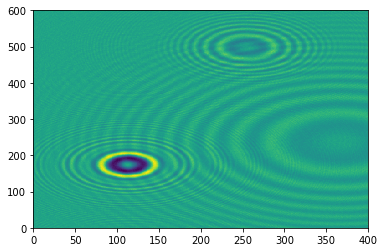

In [8]:
plt.pcolormesh(scaled_train_inputs[0])

In [10]:
train_outputs["z"].min()

14002.075

In [11]:
num_z_bins = 20
z_bins = np.linspace(train_outputs["z"].min() - 1, train_outputs["z"].max() + 1, num_z_bins)
train_z_mass = np.zeros((scaled_train_inputs.shape[0], num_z_bins), dtype=np.float32)
for i in range(train_outputs.shape[0]):
    z_pos = np.searchsorted(z_bins, train_outputs.loc[i, "z"])
    mass = 4 / 3 * np.pi * train_outputs.loc[i, "d"]
    train_z_mass[int(train_outputs.loc[i, "hid"]) - 1, z_pos] += mass
    

In [13]:
train_z_mass /= train_z_mass.sum(axis=1).reshape(-1, 1)

<BarContainer object of 20 artists>

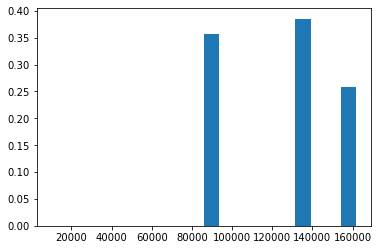

In [22]:
plt.bar(z_bins, train_z_mass[3], width=z_bins[1]-z_bins[0])

In [ ]:
# build and train the model
# conv2d_network definitions
filters = [8, 16, 32]
kernel_sizes = [5, 5, 5]
conv2d_activation = "relu"
pool_sizes = [4, 4, 4]
dense_sizes = [64, 32]
dense_activation = "relu"
lr = 0.001
optimizer = "adam"
loss = "categorical_crossentropy"
batch_size = 32
epochs = 2
verbose = 1

if not exists(out_path):
    os.makedirs(out_path)

model_start = datetime.now()
mod = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes, conv2d_activation=conv2d_activation,
                 pool_sizes=pool_sizes, dense_sizes=dense_sizes, dense_activation=dense_activation,
                 lr=lr, optimizer=optimizer, loss="categorical_crossentropy", batch_size=batch_size, epochs=epochs, verbose=verbose)
mod.fit(scaled_train_inputs, train_z_mass)
print(f"Running model took {datetime.now() - model_start} time")

In [ ]:
# save the model
print("Saving the model")
mod.model.save(join(out_path, model_name +".h5"))

In [ ]:
# predict outputs
scaled_pred_valid_outputs = pd.DataFrame(mod.predict(scaled_valid_inputs),
                                         index=scaled_valid_outputs.index,
                                         columns=scaled_valid_outputs.columns)
scaled_pred_train_outputs = pd.DataFrame(mod.predict(scaled_train_inputs),
                                         index=scaled_train_outputs.index,
                                         columns=scaled_train_outputs.columns)

# apply inverse scaler to outputs
pred_train_outputs = input_scaler.inverse_transform(scaled_pred_train_outputs)        
pred_valid_outputs = input_scaler.inverse_transform(scaled_pred_valid_outputs)

In [ ]:
# save results
pd.DataFrame(data=pred_valid_outputs).to_csv(join(out_path, "pred_valid_outputs.csv"), index=False)
pd.DataFrame(data=pred_train_outputs).to_csv(join(out_path, "pred_train_outputs.csv"), index=False)
pd.DataFrame(data=scaled_pred_train_outputs).to_csv(join(out_path, "scaled_pred_train_outputs.csv"), index=False)
pd.DataFrame(data=scaled_pred_valid_outputs).to_csv(join(out_path, "scaled_pred_valid_outputs.csv"), index=False)


## Metrics
An ideal solution to HOLODEC processing would leverage all the advantages of the instrument (unparalleled particle position and size accuracy) but reduce the drawbacks (processing time).  For this reason, the major components of the model assessment should include:
* MAE, and maximum error of each output (x, y, z, d)
* Processing time per hologram


In [ ]:
# calculate error
train_outputs = open_dataset(data_path, num_particles, "train")[output_cols].to_dataframe()
valid_outputs = open_dataset(data_path, num_particles, "valid")[output_cols].to_dataframe()
if len(output_cols) == 5:
    train_outputs = flatten_dataset(train_outputs)
    valid_outputs = flatten_dataset(valid_outputs)
error = {"train": {}, "valid": {}}
for i, var in enumerate(train_outputs.columns):
    err = mean_absolute_error(train_outputs[var], pred_train_outputs[:,i])
    error["train"][var] = err
    print (f"Training error in {var}: ", err)
for i, var in enumerate(valid_outputs.columns):
    err = mean_absolute_error(valid_outputs[var], pred_valid_outputs[:,i])
    error["valid"][var] = err
    print (f"Validation error in {var}: ", err)    

pd.DataFrame.from_dict(error, orient='index').to_csv(join(out_path, "error.csv"),index=False)
